In [1]:
#!pip install qiskit
#!pip install qiskit_machine_learning
#!pip install pylatexenc

In [2]:
#Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError
import pylatexenc

from sklearn.metrics import confusion_matrix

In [3]:
#Initiating the instance
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024)

In [4]:
#Reading the data and removing extra column unnamed
data = pd.read_csv("Test_TN.csv")
data.head()
data = data.drop("Unnamed: 0", axis = 1)
data.head()

,BOD,NH3-N,TN,MLSS,PH,AT_Temp,TN_Y
0,38,25,48,2250,8.3,22.150,12.0
1,180,29,48,2500,7.6,25.200,12.0
2,160,24,41,2140,7.2,23.650,9.7
3,170,28,44,2040,7.3,24.175,12.0
4,500,16,98,1660,7.5,25.360,13.0


In [5]:
#Filtering data so it runs faster
data = data.iloc[0:10,]

In [6]:
# Creating a binary variable based on median value
data['TN_Y_binary'] = np.where(data['TN_Y'] >= data['TN_Y'].median(), 1, 0)
data.head()

,BOD,NH3-N,TN,MLSS,PH,AT_Temp,TN_Y,TN_Y_binary
0,38,25,48,2250,8.3,22.150,12.0,1
1,180,29,48,2500,7.6,25.200,12.0,1
2,160,24,41,2140,7.2,23.650,9.7,0
3,170,28,44,2040,7.3,24.175,12.0,1
4,500,16,98,1660,7.5,25.360,13.0,1


In [7]:
#doing pandas profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
#Filtering relevant independent variables
X = data[['BOD','NH3-N','TN','MLSS','PH','AT_Temp']]
X.head()

,BOD,NH3-N,TN,MLSS,PH,AT_Temp
0,38,25,48,2250,8.3,22.150
1,180,29,48,2500,7.6,25.200
2,160,24,41,2140,7.2,23.650
3,170,28,44,2040,7.3,24.175
4,500,16,98,1660,7.5,25.360


In [9]:
# Creating binary variable
y = data['TN_Y_binary']

In [10]:
# Creating a dummy varible for VQC
y_new = np.ones((len(data),2))
print(y_new)

y_new[:,1] = np.where(y == 1, 1, 0)
y_new[:,0] = np.where(y == 0, 1, 0)
y_new

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [11]:
# Y variable for regression and scaling it from -1 to +1
y_linear = data['TN_Y']
y_linear_scaled = np.interp(y_linear, (y_linear.min(), y_linear.max()), (-1, +1))
y_linear_scaled

array([ 0.5 ,  0.5 , -0.65,  0.5 ,  1.  , -0.5 , -0.8 , -0.7 , -1.  ,
       -0.85])

In [12]:
# construct QNN
num_inputs = 6
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

In [13]:
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(X.iloc[0,:], np.random.rand(opflow_qnn.num_weights))

array([[-0.015625]])

In [14]:
# construct neural network classifier
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA())

In [15]:
# fit classifier to data
opflow_classifier.fit(X, y)

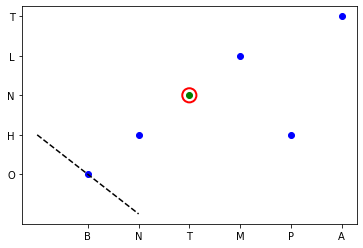

In [16]:
# evaluate data points
y_predict_opflow_classifier = opflow_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict_opflow_classifier):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [17]:
confusion_matrix(y,y_predict_opflow_classifier)

array([[0, 0, 0],
       [4, 0, 1],
       [0, 0, 5]])

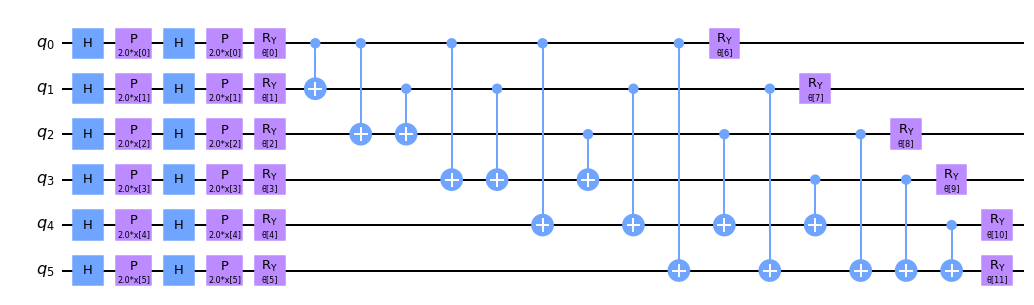

In [18]:
# construct feature map
feature_map = ZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output='mpl')

In [19]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return '{:b}'.format(x).count('1') % 2
output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [20]:
# construct QNN
circuit_qnn = CircuitQNN(circuit=qc,
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

In [21]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,
                                             optimizer=COBYLA())

In [22]:
# fit classifier to data
circuit_classifier.fit(X, y)

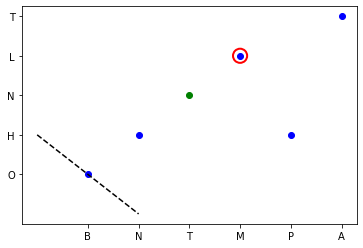

In [23]:
# evaluate data points
y_predict_circuit_classifier = circuit_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict_circuit_classifier):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [24]:
confusion_matrix(y,y_predict_circuit_classifier)

array([[4, 1],
       [1, 4]])

VQC Classifier

In [25]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          loss='cross_entropy',
          optimizer=COBYLA(),
          quantum_instance=quantum_instance)

In [26]:
vqc.fit(X, y_new)

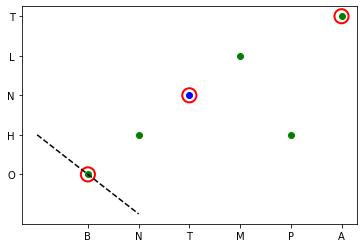

In [27]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_new, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

VQC Regression

In [28]:
#Initiating regressor
vqr = VQR(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=L_BFGS_B(),
          quantum_instance=quantum_instance)

In [ ]:
#fitting regressor
vqr.fit(X, y_linear_scaled)

In [ ]:
#Predicting the value
y_VQR = vqr.predict(X)
y_VQR

In [ ]:
# plot data
plt.plot(X.iloc[:,0], y_linear_scaled, 'bo')
# plot fitted line
plt.plot(X.iloc[:,0], y_VQR, 'go')
plt.show()

In [ ]:
plt.plot(y_linear_scaled,y_VQR, 'bo')
x = np.linspace(-1, 1,100)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.plot(x,x,color="black")

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#MSE
mse = mean_squared_error(y_linear_scaled,y_VQR)
print(mse)
# R squared error
r2s = r2_score(y_linear_scaled,y_VQR)
print(r2s)